In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.880612955927849, discriminator loss: 0.5363811916708945


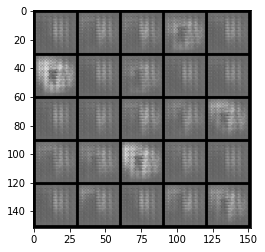

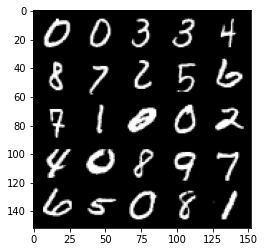

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.5230657207965852, discriminator loss: 0.39801812493801086


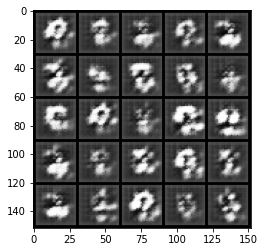

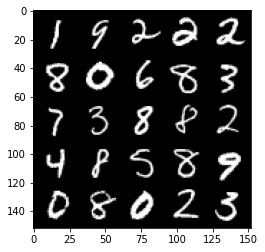

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.1308868286907676, discriminator loss: 0.5413900083899492


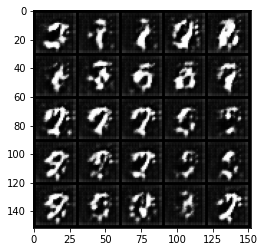

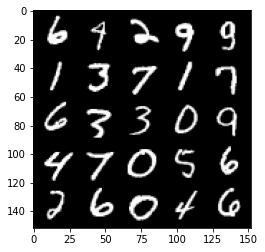

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.9384379001557825, discriminator loss: 0.5964524302482608


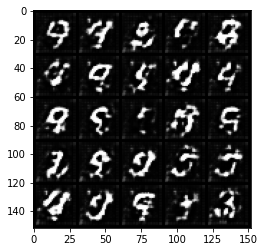

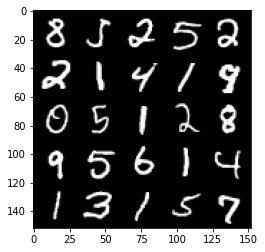

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.8914044193625452, discriminator loss: 0.6079284535646441


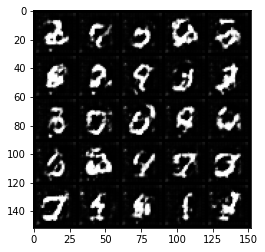

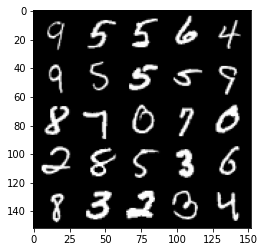

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.8537949326634402, discriminator loss: 0.6273928552865983


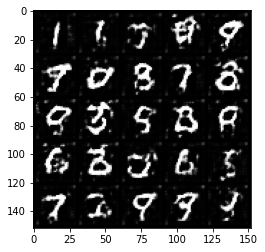

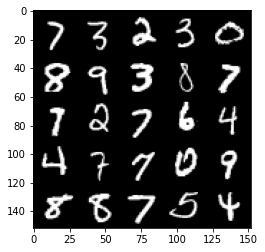

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8122531613111507, discriminator loss: 0.6509446412324901


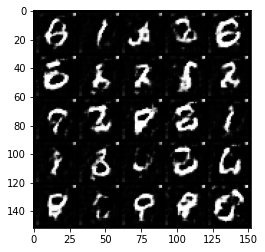

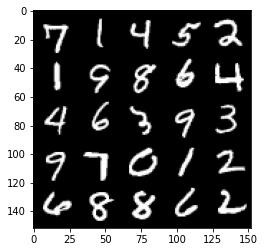

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.7876561583876608, discriminator loss: 0.6632410670518875


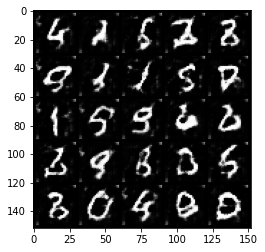

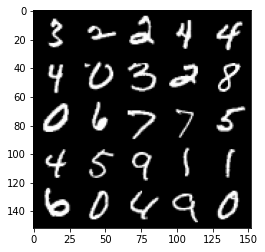

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7693917140364643, discriminator loss: 0.6745514672994614


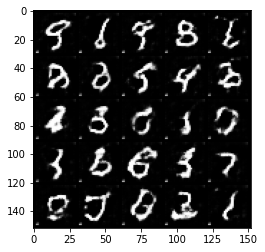

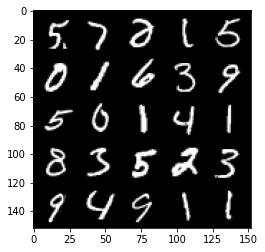

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.753083429396153, discriminator loss: 0.6779015748500824


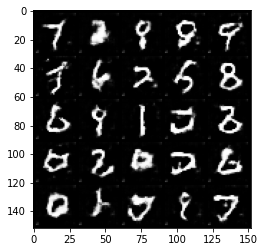

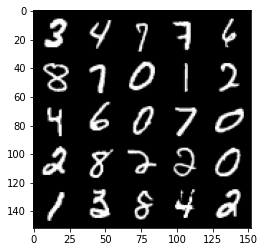

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7508039222359656, discriminator loss: 0.682262321233749


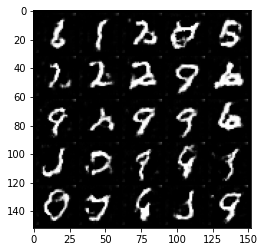

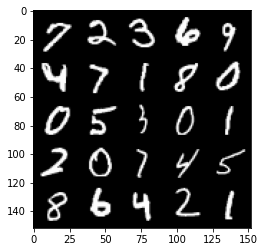

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7373823139667515, discriminator loss: 0.6862026919126507


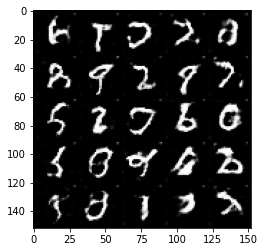

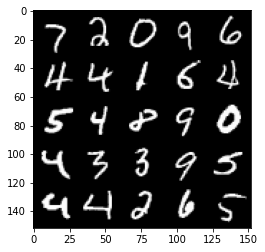

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7410441069602974, discriminator loss: 0.6851219877004626


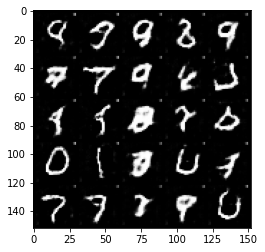

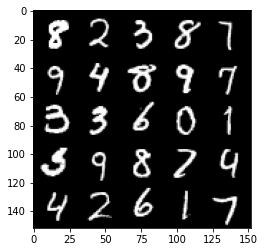

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.732505854576826, discriminator loss: 0.6890854922533038


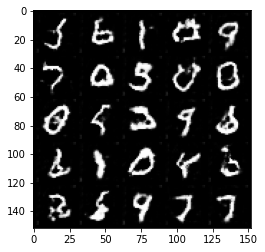

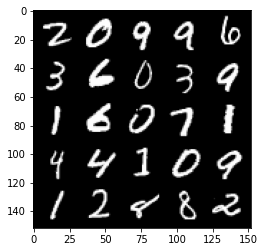

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7302011955380443, discriminator loss: 0.6892501860857013


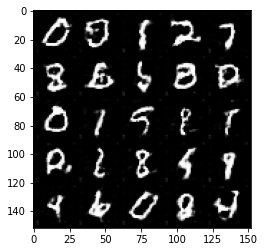

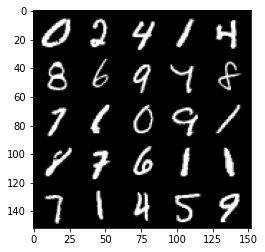

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7256714688837526, discriminator loss: 0.6928823403120049


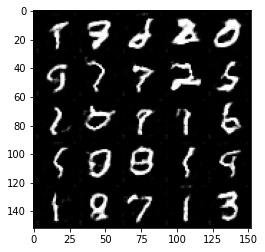

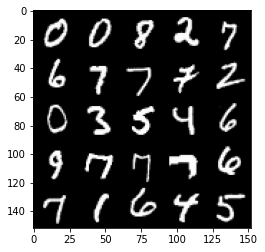

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7277515079975131, discriminator loss: 0.6921145213842388


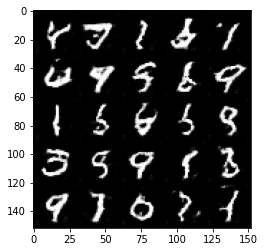

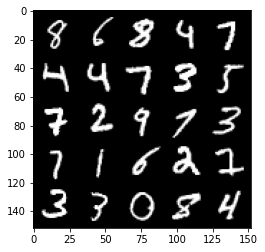

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7236535760164264, discriminator loss: 0.6909094884395598


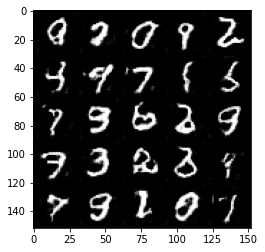

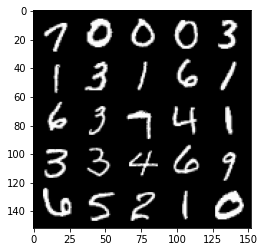

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7228604333400732, discriminator loss: 0.6922514696121214


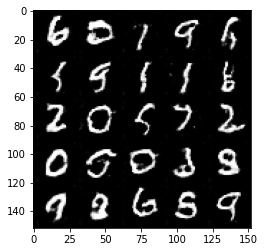

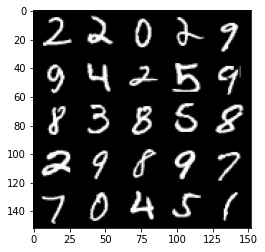

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7221949127912523, discriminator loss: 0.6915305291414254


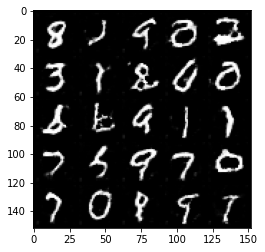

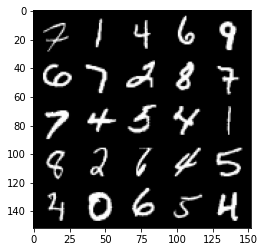

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7224707894921298, discriminator loss: 0.6918508892059329


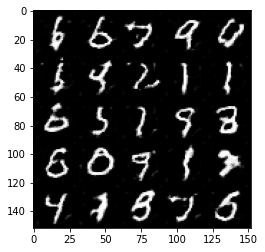

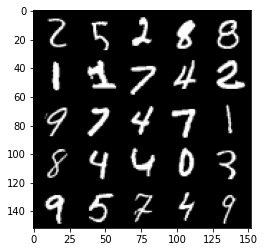

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7179247626662251, discriminator loss: 0.6922292686700826


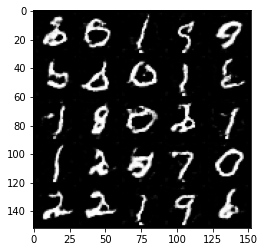

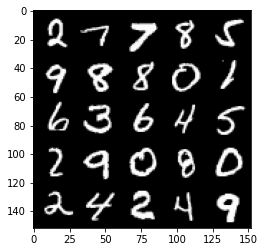

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
